In [ ]:
## !pip install -U tensorflow==2.7.1
## !pip install scikeras
!pip install pretty-confusion-matrix
!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers

In [1]:
import numpy as np 
import pandas as pd 
import csv
import pickle
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K

In [3]:
print(tf.__version__)

2.13.0


In [4]:
#  HYPERPARAMETERS
NUM_OF_ASPECTS = 7
EPOCHS = 150
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
is_BiLSTM = False # Flag to automate other pre-processing for With or Without BiLSTM variants

## ADD PATH OF THE PRE-TRAINED MODEL HERE ##
SAVE_PATH = "./Ablation-Model.h5" 

In [5]:
### CHOOSE THE EMBEDDING VARIANT YOU WANT TO TRY ###

## BERT BASE
embed_model_name = 'bert-base-uncased'

# BIO-BERT
# embed_model_name = 'gsarti/biobert-nli'

## SCIBERT
# embed_model_name = 'gsarti/scibert-nli'

### **1) DATASET** : 

I. **REVIEWS** <br>
II. **LABELS:**<br>

**A. Aspect Category**
1.  Clarity (CLA)
2. Motivation/Impact (MOT)
2.   Originality (ORI)
3.   Soundness/Correctness (SOU)
2.   Substance (SUB)
1.   Replicability (REP)
2.   Meaningful Comparison (CMP)
<br>

**B. Aspect Sentiment** <br>
1.  Positive
2.  Negative



### **2) LOAD DATASET**


**NOTE:** 
<ol>
<li> Update the URL PATH accordingly. 
<li> Select the embedding you want to try.

In [8]:
import pickle

# LOAD REVIEWS LABELS & EMBEDS
with open('./reviews_train.pickle', 'rb') as handle:
    reviews_train = pickle.load(handle)
    handle.close()

with open('./reviews_test.pickle', 'rb') as handle:
    reviews_test = pickle.load(handle)
    handle.close()

with open('./y_ohe_train.pickle', 'rb') as handle:
    y_ohe_train = pickle.load(handle)
    handle.close()
    
with open('./y_ohe_test.pickle', 'rb') as handle:
    y_ohe_test = pickle.load(handle)
    handle.close()

# SCIBERT
with open('./sci_embeds_train.pickle', 'rb') as handle:
    sci_embeds_train = pickle.load(handle)
    handle.close()
    
with open('./sci_embeds_test.pickle', 'rb') as handle:
    sci_embeds_test = pickle.load(handle)
    handle.close()
    
## BERT-BASE
with open('./bert_embeds_train.pickle', 'rb') as handle:
    bert_embeds_train = pickle.load(handle)
    handle.close()
    
with open('./bert_embeds_test.pickle', 'rb') as handle:
    bert_embeds_test = pickle.load(handle)
    handle.close()
    
# BIO-BERT
with open('./bioBert_embeds_train.pickle', 'rb') as handle:
    bio_embeds_train = pickle.load(handle)
    handle.close()
    
with open('./bioBert_embeds_test.pickle', 'rb') as handle:
    bio_embeds_test = pickle.load(handle)
    handle.close()

Update the selected embeds here:

In [9]:
### CHOOSE THE EMBEDDING VARIANT YOU WANT TO TRY ###
train_embeds = bert_embeds_train
test_embeds = bert_embeds_test

In [7]:
aspect_categories = y_ohe_train.columns[:-1]
y_ohe_train['polarity'] = np.where(y_ohe_train['polarity'] == -1, 0, 1)
y_ohe_test['polarity'] = np.where(y_ohe_test['polarity'] == -1, 0, 1)

In [10]:
train_embeds.shape , y_ohe_train.shape

(TensorShape([161235, 1, 768]), (161235, 8))

In [11]:
test_embeds.shape , y_ohe_test.shape

(TensorShape([40309, 1, 768]), (40309, 8))

### **3) EMBEDDING MODEL -- SciBERT, BERT-BASE, BioBERT**

In [12]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [13]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name) 
embed_model = AutoModel.from_pretrained(embed_model_name)

In [14]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

# SAMPLE SCIBERT
sent = ['This work studies the predictive uncertainty issue of deep learning models.']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [15]:
# PRE-PROCESS
def Embed(reviews, y_train, model):
    embed_arr = []
    start = reviews.index[0]
    for idx in range(len(reviews.index)):
        print(start + idx)
        outputs = sent2embed(model, reviews.loc[start+idx])
        embed_arr.append([outputs[1].detach().numpy()[0]])

    embed_train_arr = tf.stack(embed_arr)

    return embed_train_arr, y_train

### **4) Attention**

In [16]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences , 
        })
        return config


    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a
        
        return K.sum(output, axis=1) 

In [36]:
if not is_BiLSTM:
    ## ONLY IF BiLSTM NOT there -- REDUCE DIMENSION OF DATASET BY 1DIM 
    train_embeds2 = np.array([row[0] for row in train_embeds ])
    test_embeds2 = np.array([row[0] for row in test_embeds ])

# else:
#     # OTHER CASE
#     train_embeds2 = train_embeds
#     test_embeds2 = test_embeds 

In [38]:
train_embeds2 = np.array([row[0] for row in train_embeds ])
test_embeds2 = np.array([row[0] for row in test_embeds ])
train_embeds2.shape

(161235, 768)

### **5) Define Ablation Models**

Uncomment the variant you want to try

#### A) WithoutBILSTM Variant

In [39]:
embed = Input(shape=  (MAXLEN,), name='INPUT') # without BiLSTM
repeat_op = RepeatVector(1)(embed)

attentions=[]
for i in range(NUM_OF_ASPECTS):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)

concate_attention  = Concatenate()(attentions)
flatten = Flatten()(concate_attention)

# BRANCH 1
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2
b2_x =  Dense(60, activation='relu', name='POLARITY_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='POLARITY_OUTPUT')(b2_x)

multitask_model = Model(inputs=embed, outputs=[category_output, polarity_output])

#### B) Without Attention Variant

In [24]:
embed = Input(shape=  (None, MAXLEN), name='INPUT') 

biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
flatten = Flatten()(biLSTM)

# BRANCH 1
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2
b2_x =  Dense(60, activation='relu', name='POLARITY_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='POLARITY_OUTPUT')(b2_x)

multitask_model = Model(inputs=embed, outputs=[category_output, polarity_output])

#### C) Without Both (BiLSTM & Attention) Variant

In [ ]:
# embed = Input(shape=  (MAXLEN,), name='INPUT')

# # BRANCH 1
# b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(embed)
# d1 = Dropout(0.15)(b1_x)
# category_output = Dense(NUM_OF_ASPECTS, activation='softmax', name='CATEGORY_OUTPUT')(d1)

# # BRANCH 2
# b2_x =  Dense(60, activation='relu', name='POLARITY_DENSE')(embed)
# polarity_output = Dense(1, activation='sigmoid', name='POLARITY_OUTPUT')(b2_x)

# multitask_model = Model(inputs=embed, outputs=[category_output, polarity_output])

In [40]:
metrics =[ 
    'accuracy', 
    tf.keras.metrics.Precision(), 
    tf.keras.metrics.Recall()
]

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)

loss = { 'CATEGORY_OUTPUT': 'categorical_crossentropy', 
        'POLARITY_OUTPUT': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT': 1.0, 
               'POLARITY_OUTPUT': 1.0
              }


multitask_model.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam', 
                        metrics=['accuracy']) 


multitask_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 768)]                0         []                            
                                                                                                  
 repeat_vector_4 (RepeatVec  (None, 1, 768)               0         ['INPUT[0][0]']               
 tor)                                                                                             
                                                                                                  
 attention_43 (Attention)    (None, 768)                  769       ['repeat_vector_4[0][0]']     
                                                                                                  
 attention_45 (Attention)    (None, 768)                  769       ['repeat_vector_4[0][0]'

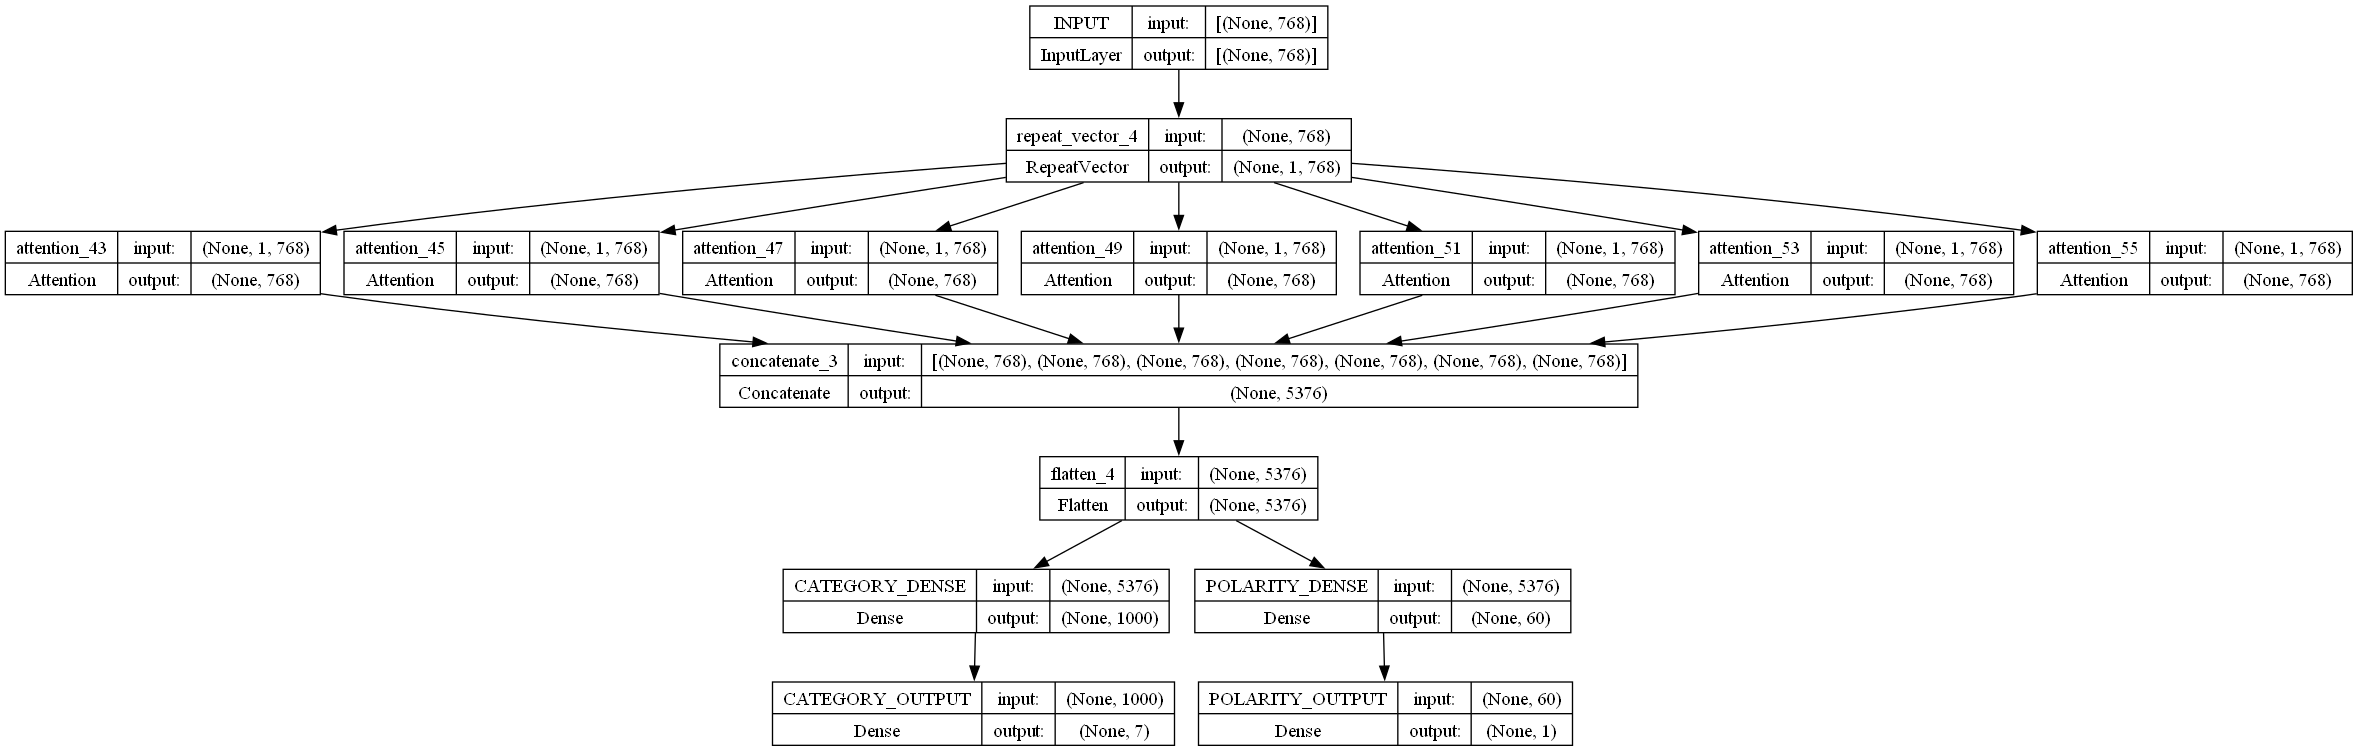

In [41]:
tf.keras.utils.plot_model(multitask_model, to_file='multi-task_model.png', show_shapes=True)

### **6) FIT MODEL**

In [43]:
history = multitask_model.fit(
                          train_embeds2, 
                          y =  {
                          'CATEGORY_OUTPUT': y_ohe_train[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_train.polarity.values
                          },  
                           validation_data = (test_embeds2, {
                          'CATEGORY_OUTPUT': y_ohe_test[aspect_categories].values, 
                          'POLARITY_OUTPUT': y_ohe_test.polarity.values
                           }),
                           epochs = 10,
                           shuffle=True,
                           verbose=2
                          )

Epoch 1/10
5039/5039 - 440s - loss: -1.8076e+05 - CATEGORY_OUTPUT_loss: 1.3886 - POLARITY_OUTPUT_loss: -1.8076e+05 - CATEGORY_OUTPUT_accuracy: 0.4847 - POLARITY_OUTPUT_accuracy: 8.0628e-05 - val_loss: -4.9316e+05 - val_CATEGORY_OUTPUT_loss: 1.2160 - val_POLARITY_OUTPUT_loss: -4.9316e+05 - val_CATEGORY_OUTPUT_accuracy: 0.5476 - val_POLARITY_OUTPUT_accuracy: 0.0000e+00 - 440s/epoch - 87ms/step
Epoch 2/10
5039/5039 - 472s - loss: -1.0390e+06 - CATEGORY_OUTPUT_loss: 1.1563 - POLARITY_OUTPUT_loss: -1.0390e+06 - CATEGORY_OUTPUT_accuracy: 0.5730 - POLARITY_OUTPUT_accuracy: 0.0000e+00 - val_loss: -1.6645e+06 - val_CATEGORY_OUTPUT_loss: 1.1270 - val_POLARITY_OUTPUT_loss: -1.6645e+06 - val_CATEGORY_OUTPUT_accuracy: 0.5762 - val_POLARITY_OUTPUT_accuracy: 0.0000e+00 - 472s/epoch - 94ms/step
Epoch 3/10
5039/5039 - 421s - loss: -2.5309e+06 - CATEGORY_OUTPUT_loss: 1.0882 - POLARITY_OUTPUT_loss: -2.5309e+06 - CATEGORY_OUTPUT_accuracy: 0.6016 - POLARITY_OUTPUT_accuracy: 0.0000e+00 - val_loss: -3.4338e+

KeyboardInterrupt: 

In [ ]:
multitask_model.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

In [ ]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH = SAVE_PATH
# LOAD_PATH = "../input/berth5/MultiTask-Ablation_WithoutAttention-epoch150.h5"
model = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

model.evaluate(test_embeds2, [y_ohe_test[aspect_categories].values, y_ohe_test.polarity.values] )

### **7) ANALYSIS**

In [ ]:
history.history.keys()

In [ ]:
metrics_keys = list(history.history.keys())

loss = history.history[metrics_keys[0]]
category_loss = history.history[metrics_keys[1]]
polarity_loss = history.history[metrics_keys[2]]
category_acc = history.history[metrics_keys[3]]
polarity_acc = history.history[metrics_keys[4]]
val_loss = history.history[metrics_keys[5]]
val_category_loss = history.history[metrics_keys[6]]
val_polarity_loss = history.history[metrics_keys[7]]
val_category_acc = history.history[metrics_keys[8]]
val_polarity_acc = history.history[metrics_keys[9]]


print("\nCATEGORY ACCURACY : " , category_acc)
print("\nPOLARITY ACCURACY : " , polarity_acc)
print("\nVAL CATEGORY ACCURACY : " ,val_category_acc)
print("\nVAL POLARITY ACCURACY : " ,val_polarity_acc)

print("\nLOSS : " , loss)
print("\nVAL LOSS : " , val_loss)
print("\nCATEGORY LOSS : " , category_loss)
print("\nCATEGORY VAL LOSS : " , val_category_loss)
print("\nPOLARITY LOSS : " , polarity_loss)
print("\nVAL POLARITY LOSS : " , val_polarity_loss)

In [ ]:
metrics = history.history['loss']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 23))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, category_acc, label='Training Accuracy')
plt.plot(epochs_range, val_category_acc, label='Validation Accuracy')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15, )
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, polarity_acc, label='Training Accuracy')
plt.plot(epochs_range, val_polarity_acc, label='Validation Accuracy')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION ACCURACY')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('Accuracy', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17, loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(epochs_range,category_loss, label='Training Loss')
plt.plot(epochs_range, val_category_loss, label='Validation Loss')
plt.title('ASPECT CATEGORY TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)

plt.subplot(2, 2, 4)
plt.plot(epochs_range,polarity_loss, label='Training Loss')
plt.plot(epochs_range, val_polarity_loss, label='Validation Loss')
plt.title('ASPECT SENTIMENT TRAINING VS VALIDATION LOSS')
plt.xlabel('Epochs', fontsize=19, labelpad=20)
plt.ylabel('MSE', fontsize=19, labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=17)
           
           
plt.show()




### **8)VALIDATION**

In [ ]:
categories = y_ohe_train.columns[:-1]
polarity_labels = ['POSITIVE', 'NEGATIVE']

In [ ]:
# ASPECT CATEGORY
y_pred_aspect = multitask_model.predict(test_embeds2)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_ohe_test[aspect_categories].values, axis=1)


In [ ]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_ohe_test.polarity.values, y_pred_polarity)

In [ ]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect_categories, aspect_acc):
    print('',cat,"\t",round(acc, 3))
    
# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

In [ ]:
plt.figure(figsize=(25, 10))
sns.heatmap(cm_aspect, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=categories, xticklabels=categories)

plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('ASPECT CATEGORY CONFUSION MATRIX')
plt.show()

sns.heatmap(cm_polarity, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=polarity_labels, xticklabels=polarity_labels)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('ASPECT POLARITY CONFUSION MATRIX')
plt.show()

In [ ]:
from pretty_confusion_matrix import pp_matrix

df_cm = pd.DataFrame(cm_aspect, index=categories, columns=categories)
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)

In [ ]:
df_polarity = pd.DataFrame(cm_polarity, index=polarity_labels, columns=polarity_labels)
cmap = 'PuRd'
pp_matrix(df_polarity, cmap=cmap)

In [ ]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_ohe_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

## **INFERENCE MODEL**

In [ ]:
def predictPreprocess(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack([pred_X])
  return embed_X

def predictPreprocessWithoutBiLSTM(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack(pred_X)
  return embed_X

In [ ]:
def inferenceModel(multi_model, embed_model, sent):
    labels = y_ohe_train.columns[:-1]
#     labels = ['CLA', 'CMP', 'MOT', 'ORI', 'REP', 'SOU', 'SUB', 'SUM']
    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        if is_BiLSTM:
            test_embed = predictPreprocess(embed_model, s.strip())
        else:
            test_embed = predictPreprocessWithoutBiLSTM(embed_model, s.strip())
            
        category_probab = multi_model.predict(test_embed)
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        results.append([labels[category_label_idx] , category_polarity, category_label])
        
    return results


In [ ]:
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy 
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . The approach 
is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)

In [ ]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is 
conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces 
an interesting idea to address an important topic .'''
op = inferenceModel(model,embed_model, sent)

print('PREDICTED OUTPUT :', op)